# RL homework 4

-------------------------------


**Name:** Wu Zhi

**SN:** 17040772

-----------------------------------


**Start date:** *29th March 2018*

**Due date:** *19th April 2018, 4:55 pm*

------------------------------------

## How to Submit

When you have completed the exercises and everything has finsihed running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **studentnumber_RL_hw4.ipynb** before the deadline above.

Also send a **sharable link** to the notebook at the following email: ucl.coursework.submit@gmail.com. You can also make it sharable via link to everyone, up to you.

Please compile all results and all answers to the understanding questions into a PDF. Name convention: **studentnumber_RL_hw4.pdf**. Do not include any of the code (we will use the notebook for that). 

**Page limit: 10 pg **


## Context

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

## Background reading

* Sutton and Barto (2018), Chapters 6-7 + 9-11

# Setup

### Import Useful Libraries

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import namedtuple

### Set options

In [0]:
np.set_printoptions(precision=3, suppress=1)

### Helper functions

In [0]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = grid.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(values, colormap='pink', vmin=None, vmax=None):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_action_values(action_values, vmin=None, vmax=None):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    plot_values(q[..., a], vmin=vmin, vmax=vmax)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")


def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)
  

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  # plt.ylim((0, 1.5))
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  # plt.ylim((0, 1.5))
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)
  
def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

### A small MRP

In [0]:
class SmallMRP(object):

  def __init__(self, p=0.1):
    self._state = 0
    self._p = p

  def get_state(self):
    return self._state

  def step(self):
    reward = 0
    discount = 1
    if self._state == 0:
      self._state = 1
    else:
      if np.random.random() < self._p:
        self._state = 0
        discount = 0
      else:
        self._state = 1

    return reward, discount, self.get_obs()

## Assignment 1 [50pts in total]

We are going to analyze the simple Markov reward process (MRP - a MRP is an MDP without actions or, equivalently, with a single action in each state) defined in the code cell above.  It consists of two states.  The reward is zero everywhere.  When we are in state $s_0$, we always transition to $s_1$.  If we are in state $s_1$, there is a probability $p$ (which is set to 0.1 by default in the code above) of terminating, after which the next episode starts in $s_0$ again.  With a probability of $1 - p$, we transition from $s_1$ back to itself again.  The discount is $\gamma = 1$ on non-terminal steps.

#### [1pt] Question 1.1
What is the optimal value in each state?

**Answer**: The optimal value is 0 in each state.

#### [1pt] Question 1.2
Instead of a tabular representation, consider a single feature $\phi$, which takes the values $\phi(s_0) = 1$ and $\phi(s_1) = 4$.  Now consider using linear function approximation, where we learn a value $\theta$ such that $v_{\theta}(s) = \theta \times \phi(s) \approx v(s)$, where $v(s)$ is the true value of state $s$.  What is the optimal value of $\theta$?

**Answer**: Because $v_{\theta}(s) = \theta * \phi (s) \approx v(s) = 0$, then $\theta = 0$

#### [8pts] Question 1.3
Suppose $\theta_0 = 1$, and suppose we update this parameter with TD(0) with a step size of $\alpha = 0.1$.  What is the expected value of $\mathbb{E}[ \theta_T ]$ if we step through the MDP until it terminates after the first episode, as a function of $p$?  (Note that $T$ is random.)

**Answer**:

The updata equation is:
$$\triangle \theta_t = \alpha(R_{t+1} + \gamma v_{\theta}(s_{t+1} - v_{\theta}(s_{t})))\phi_t$$

For the path $s_0 \rightarrow s_1 \rightarrow terminating$, the $\theta _T$ is given by:

$$\triangle \theta_0 = 0.1 * (0 + 1 * 1 * 4 - 1 * 1) * 1 = 0.3$$
$$\theta_1 = 1+0.3 = 1.3$$

For the path $s_0 \rightarrow s_1 \rightarrow s_1\rightarrow terminating$, the $\theta _T$ is given by:

$$\triangle \theta_1 = 0.1 * (0 + 1 * 1.3 * 4 - 1.3 * 4) * 1 = 0$$
$$\theta_1 = 1.3 + 0 = 1.3$$

Thus, for path $s_0 \rightarrow s_1 \rightarrow  ... \rightarrow s_1\rightarrow terminating$, $\theta _T = 1.3 (T>=1)$

After terminating, the state move from $s_1$ to $s_0$, and the change for $\theta_T$ is :

$$\triangle \theta_T = 0.1 * (0 + 0 - \theta_T * 4) * 4 = -1.6 \theta_T$$
$$\triangle \theta_{T + 1} = \triangle \theta_T  + (-1.6 \theta_T) = -0.6 \theta_T$$

In this problem, $\theta_T = 1.3 * -0.6 = -0.78$, and here the function is independent with p. Thus, the expectation is:

$$\mathbb{E}[ \theta_T ] = -0.78$$

#### [5pts] Question 1.3
If $p=0.1$, how many episodes does it take, starting from $\theta_0 = 1$, until $| v(s) - \mathbb{E}[v_{\theta}(s)] | < 0.5$ for all $s$, where the expectation is over the expected updates to $\theta$?

**Answer**:

 For each episode, the expectation of $\theta$ is -0.78: $\mathbb{E}[\theta_{T+1}] = -0.78 * \mathbb{E}[\theta_{T}]$
 
 For the state $s_1$, we need make sure that:
 
 $$| v(s_1) - \mathbb{E}[v_{\theta}(s_1)] | < 0.5$$
 $$|0 - 4 * (-0.78)^n|<0.5$$
 
 Then for an integer $n$, we can get the answer: $n \geq 9$

 For the state $s_0$, we need make sure that:
 
 $$| v(s_0) - \mathbb{E}[v_{\theta}(s_0)] | < 0.5$$
 $$|0- 1 * (-0.78)^n|<0.5$$
 
So, we can get the answer: $n \geq 3$
 
Overall, after at least **9** episodes $| v(s) - \mathbb{E}[v_{\theta}(s)] | < 0.5$.

#### Synchronous updates
Consider the following algorithm: we use TD to update the parameters, but instead of using the online data, we assume we can actively sample a transition from both states.  We then update $\theta$ using both samples:
$$
\theta_{n+1} = \theta_n + \alpha \delta_0 \phi(s_0) + \alpha \delta_1 \phi(s_1) \,,
$$
where $\delta_i$ is a sampled one-step TD error when transitioning from state $s_i$.

#### [10pts] Question 1.4

What is the value of $\mathbb{E}[\theta_n]$, as a function of $n$ and $p$?

**Answer**: 
The expectation of $\theta_{n+1}$ is: 

$$\mathbb{E}[\theta_{n+1}] = \mathbb{E}[\theta_{n}] + \alpha \phi (s_0) \mathbb{E}[\delta_0] + \alpha \phi (s_1) \mathbb{E}[\delta_1]$$
 $$where \delta = r + \gamma v_{\theta}(s_{t+1}) -v_{\theta}(s_{t})$$

Then we can calaulate expectation of $\delta_0$ and $\delta_1$:

$$\mathbb{E}[\delta_0] = (\phi (s_1) - \phi (s_0))\mathbb{E}[\theta_{n}] = 3\mathbb{E}[\theta_{n}]$$
$$\mathbb{E}[\delta_1] = p*(0 - \phi (s_1)\mathbb{E}[\theta_{n}])+ (1-p) * 0 = -4p\mathbb{E}[\theta_{n}]$$

Thus the update equation is:

$$\mathbb{E}[\theta_{n+1}] = \mathbb{E}[\theta_{n}] + 3\mathbb{E}[\theta_{n}] + 4 * (-4p\mathbb{E}[\theta_{n}]) = (1 + 3\alpha - 16p\alpha)\mathbb{E}[\theta_{n}]$$

Assuming start from $\theta_0$, the value of $\mathbb{E}[\theta_n]$ can be written as:

$$ \mathbb{E}[\theta_{n}] = (1 + 3\alpha - 16\alpha p)^n \theta_0$$

#### [5pts] Question 1.5

For which values of $p$ does not $\theta$ converge to the optimal solution?

**Answer**: The value of $\mathbb{E}[\theta_n]$ can be written as:

$$ \mathbb{E}[\theta_{n}] = (1 + 3\alpha - 16\alpha p)^n \theta_0$$
 
 If $\theta$ converge to the optimal solution which is 0, the requirement is:

 $$(1 + 3\alpha - 16\alpha p)^n \simeq 0$$
 
 Thus,  for $\theta$ does not converge to 0, the requirement is
 $$|1 + 3\alpha - 16\alpha p| \geq 1$$
 
 The range of value of p is:
 
 $$\frac{2 + 3\alpha}{16 \alpha} \leq p \leq \frac{3}{16}$$
 
Hence, $\alpha = 0.1$ here, so $\frac{2 + 3\alpha}{16 \alpha} = \frac{23}{16}$, so the final answer is 

$$p \leq \frac{3}{16}$$
 

#### [10pts] Question 1.5
Why doesn't it?  TD is known to converge, with linear function approximation, under certain assumptions.  Explain for this concrete case why the algorithm does not converge, and explain which general assumption is violated that would otherwise ensure convergence of linear TD (in at most 200 words).

**Answer**: 

$$\theta_{n+1} = \begin{cases}
&\theta_n + \frac{1}{10}(3\theta_n-16\theta_n) = \theta_n -1.3\theta_n & \text{with } p \\
&\theta_n + \frac{1}{10}(3\theta_n) = \theta_n + 0.3\theta_n & \text{with } 1-p
\end{cases}$$
So $$\mathbb{E}[\theta_{n+1}\mid \theta_n] = \theta_n - A \theta_n = (1-A)\theta_n$$ $$where A = 1.3p - 0.3(1-p)=-0.3+1.6p$$

In general linear TD(0) algorithm, the convergence is guaranteed if $\mathbf{A}$ (with shape $n$ by $n$, where $n$ is the dimension of the feature space, in our case $n=1$ and we have merge the step size $\alpha$ into $A$ above) is positive definite so that in $(\mathbf{I}-\alpha\mathbf{A})\theta_n$, $\theta_n$ will be reduced toward zero and stability is assured. 

In the above case, the convergence is guaranteed if $A>0$ (actually we would also require $A<2$ but since $p\leq1$ we can ignore this), that is $p>\frac{3}{16}$. So when $p\leq\frac{3}{16}$, the assumption of the positive definiteness of $A$ will be violated, resulting in divergence.

#### [10pts] Question 1.5
Describe a way to change the algorithm to obtain convergence of $\theta$, for any $p$, without changing the sampling or the value function (which should remain as $v_{\theta}(s) = \theta \times \phi(s)$).  Note that the sampling is not sequential, so for instance you cannot add memory of previous states.  (At most 200 words.)

**Answer**: 

Convergence can be obtained by setting different step sizes the two samples in each step, now 
$$\theta_{n+1} = \theta_n + \alpha_0 \delta_0 \phi(s_0) + \alpha_1 \delta_1 \phi(s_1) 
$$ As before, $A = 16\alpha_1p-3\alpha_0$. Solve $0<A<2$ we have 

$$\frac{3\alpha_0}{16\alpha_1}<p<\frac{2+3\alpha_0}{16\alpha_1}$$ 

In order to have this inequality holds for all $p\in(0,1]$, we can set $\alpha_0$ and $\alpha_1$ as finctions of $n$ such that 

$$\lim_{n\to\infty}\frac{3\alpha_0(n)}{16\alpha_1(n)}=0$$ and $$\lim_{n\to\infty}\frac{2+3\alpha_0(n)}{16\alpha_1(n)}\geq1$$

We can set $\alpha_0(n)$ as a non-negative decreasing function of $n$ and $\alpha_1(n)$ as an increasing function of $n$ with supremum $\frac{2}{16}$, such that the two limits above will hold. Then the convergence is guaranteed whenever $p>0$. Note that we cannot reach convergence if $p=0$ as $\theta_n$ will go to $\infty$ as $n$ goes to $\infty$.



## Assignment 2 [50pts in total + 10 BONUS pts]

### A grid world

In [0]:
class Grid(object):

  def __init__(self, tabular=True, vision_size=1, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1, -5, -1, -1, -1, -1, -6, -1, -1, -1, -1, 10, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    ])
    self._start_state = (3, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy
    self._tabular = tabular
    self._vision_size = vision_size

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout != -1, interpolation="nearest")
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(2, 2, r"$\mathbf{S}$", ha='center', va='center')
    goal_y, goal_x = np.where(self._layout==10)
    plt.text(goal_x, goal_y, r"$\mathbf{G}$", ha='center', va='center')
    goal_y, goal_x = np.where(self._layout==-5)
    plt.text(goal_x, goal_y, r"$\mathbf{D}$", ha='center', va='center')
    goal_y, goal_x = np.where(self._layout==-6)
    plt.text(goal_x, goal_y, r"$\mathbf{D}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

  def get_obs(self):
    y, x = self._state
    return self.get_obs_at(x, y)

  def get_obs_at(self, x, y):
    if self._tabular:
      return y*self._layout.shape[1] + x
    else:
      v = self._vision_size
      location = np.clip(-self._layout[y-v:y+v+1,x-v:x+v+1], 0, 1)
      return location

  def step(self, action):
    y, x = self._state
    
    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    discount = 0.98
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -1
      new_state = (y, x)
    elif self._layout[new_y, new_x] != 0: # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    else:
      reward = (new_y + new_x) / np.sum(self._layout.shape)
    if self._noisy:
      width = self._layout.shape[1]
      reward += 2*np.random.normal(0, width - new_x + new_y)
    
    self._state = new_state

    return reward, discount, self.get_obs()
    

### The grid

The cell below shows the `Grid` environment that we will use. Here `S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-1` for bumping into a wall, `+10` for reaching the goal, and `(x + y)/(height + width)` otherwise, which encourages the agent to go right and down.  The episode ends when the agent reaches the goal.  At the end of the left-most two corridors, there are distractor 'goals' (marked `D`) that give a reward of $-5$ and $-6$, and then also terminate the episode.  The discount, on continuing steps, is $\gamma = 0.98$.  Feel free to reference the implemetation of the `Grid` above, under the header "a grid world".

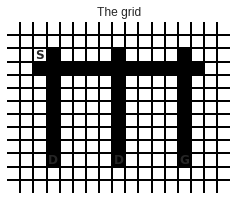

In [6]:
grid = Grid()
grid.plot_grid()


## Implement agents
**[10 pts]** In the next code cell, implement an agent that uses **tabular Sarsa** to learn action values.  The agent should act according to an $\epsilon$-greedy policy with respect to its action values.

The agent will be initialized with:
```
agent = Sarsa(number_of_states=grid._layout.size,
              number_of_actions=4,
              grid.get_obs())
```

In [0]:
class Sarsa(object):

  def __init__(self, number_of_states, number_of_actions, initial_state, step_size=0.1):
    
    self.s = initial_state
    self.lr = step_size
    self.q = np.zeros((number_of_states, number_of_actions))
    self.last_action = 0
    
  @property
  def q_values(self):
    return self.q

  def step(self, r, g, s):
    
    next_a = epsilon_greedy(self.q[s,:], 0.1)
    
    self.q[self.s, self.last_action] +=  self.lr * (r + g * self.q[s, next_a] - self.q[self.s,self.last_action]) 
 
    self.s = s
    self.last_action = next_a
    
    return self.last_action

**[20 pts]** Implement an agent that uses **neural Sarsa** to learn action values.  The agent should expect a nxn input which it should flatten into a vector, and then pass through a multi-layer perceptron with a single hidden layer with 100 hidden nodes and ReLU activations.  Each weight layer should also have a bias.  Initialize all weights uniformly randomly in $[-0.05, 0.05]$.

```
NeuralSarsa(number_of_features=(2*vision_size + 1)**2,
            number_of_hidden=100,
            number_of_actions=4,
            initial_state=grid.get_obs(),
            step_size=0.01)
```

The number `vision_size` will be either 1 or 2 below.  The input vector will be of size $(2v + 1)^2$, which will correspond to a square local view of the grid, centered on the agent, and of size $(2v + 1) \times (2v + 1)$ (so either 3x3 or 5x5).

You are allowed, but not mandated, to use TensorFlow to implement this agent.  (The network is small enough that you can also use numpy, but then you have to implement your own backprop.)  Please document the code clearly, especially on non-trivial operations.

In [0]:
class NeuralSarsa(object):

  def __init__(self, number_of_features, number_of_hidden, number_of_actions, initial_state, step_size=0.01):
    self._number_of_features = number_of_features
    self._number_of_hidden = number_of_hidden
    self._number_of_actions = number_of_actions
    self._s = initial_state
    self._a = 0
    self._alpha = step_size
    self.getgraph()
    self.runsess()
    
  def q(self, obs):
    # This function should give the vector of action values for observation obs
    reshape = obs.reshape(1, -1)
    q_s = self.sess.run(self.q_t1, feed_dict = {self.s_t1: reshape})
    return q_s.reshape(4,)
    
  
  def step(self, r, g, s):
    # This function should return an action
    
    next_a = epsilon_greedy(self.q(s), 0.1)
    feed_dict = {self.s_t: self._s, self.s_t1: s, self._r: r, self._g: g, self.a_t: self._a, self.a_t1: next_a}
    self.sess.run(self.optimizer, feed_dict = feed_dict)
    
    self._s = s
    self._a = next_a
    
    return self._a
    
    
  def variable(self, a, b):
    return tf.Variable(tf.random_uniform([a, b], -0.05, 0.05))
  
  def initial(self):
    self.s_t = tf.placeholder(tf.int32, [None, None])
    self.s_t1 = tf.placeholder(tf.int32, [None, None])
    self.a_t = tf.placeholder(tf.int32, None) 
    self.a_t1 = tf.placeholder(tf.int32, None)
    self._r = tf.placeholder(tf.float32, None)
    self._g = tf.placeholder(tf.float32, None)
    
    self._w1 = self.variable(self._number_of_features, self._number_of_hidden)
    self._b1 = self.variable(1, self._number_of_hidden)
    self._w2 = self.variable(self._number_of_hidden, self._number_of_actions )
    self._b2 = self.variable(1,self._number_of_actions )
    
  
  def neuralnet(self, x):
    flatten = tf.cast(tf.reshape(x, [1,-1]), tf.float32)
    hidden = tf.nn.relu(tf.matmul(flatten, self._w1) + self._b1)
    output = tf.matmul(hidden, self._w2) + self._b2
    return output
    
  def runsess(self):
    self.sess = tf.Session()
    self.sess.run(tf.global_variables_initializer())
    
  def getgraph(self):
    tf.reset_default_graph()
    self.initial()
    
    self.q_t = self.neuralnet(self.s_t) # Get q-values at s_t [1 x 4]
    self.q_t1 = self.neuralnet(self.s_t1) # Get q-values at s_t+1 [1 x 4]
    # next_a (a_t+1) will be chosen in the step function (evaluate and then feed back in)

    
    self._delta = self._r + self._g * self.q_t1[:, self.a_t1] - self.q_t[:, self.a_t]
    self.q_loss = tf.square(self._delta)/2
    
    # Use SGD to find the variables
    self.optimizer = tf.train.GradientDescentOptimizer(self._alpha).minimize(self.q_loss)

# Analyse Results

### Run the cells below to train the tabular and neural SARSA agents and to generate plots.

This trains the agents the Grid problem with an epsilon of 0.1.

The plots below will show action values for each of the actions, as well as a state value defined by $v(s) = \sum_a \pi(a|s) q(s, a)$.

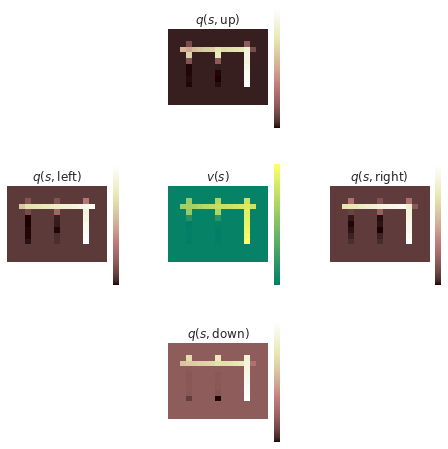

In [9]:
grid = Grid()
agent = Sarsa(number_of_states=grid._layout.size,
              number_of_actions=4, 
              initial_state = grid.get_obs())
run_experiment(grid, agent, int(1e5))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

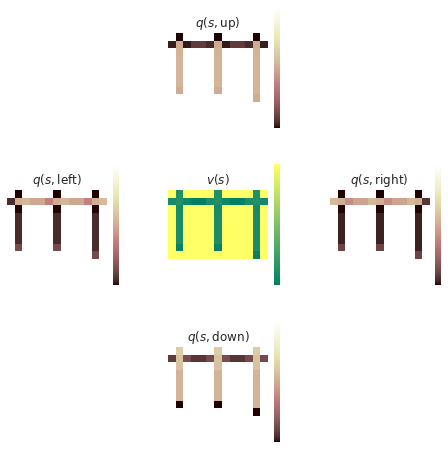

In [10]:
vision_size = 1
grid = Grid(tabular=False, vision_size=vision_size)
agent = NeuralSarsa(number_of_features=(2*vision_size + 1)**2,
                    number_of_hidden=100,
                    number_of_actions=4,
                    initial_state=grid.get_obs(),
                    step_size=0.01)
run_experiment(grid, agent, int(1e5))
h, w = grid._layout.shape
obs = np.array([[grid.get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
qs = np.array([[[agent.q(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
plot_action_values(qs)

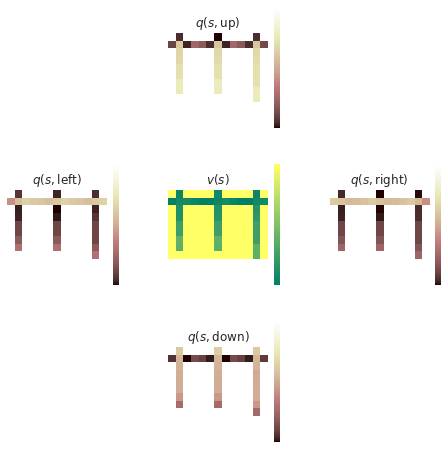

In [11]:
vision_size = 2
grid = Grid(tabular=False, vision_size=vision_size)
agent = NeuralSarsa(number_of_features=(2*vision_size + 1)**2,
                    number_of_hidden=100,
                    number_of_actions=4,
                    initial_state=grid.get_obs(),
                    step_size=0.01)
run_experiment(grid, agent, int(1e5))
h, w = grid._layout.shape
obs = np.array([[grid.get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
qs = np.array([[[agent.q(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
plot_action_values(qs)

## Questions

Consider the greedy policy with respect to the estimated values

**[5 pts]** Which algorithm performed best?  Why?

**Answer**: 

Tabular Sarsa performed the best since the environment is deterministic and the tabular can update the q values with greater precision compared to that using of neural network no cunts leave here till we find out what cunts did it.

**[5 pts]** Is there a difference in the solution found by Neural Sarsa with a vision size of 1 (so 3x3 local observations), and a vision size of 2 (so 5x5 local observations)?  Why?

**Answer**:

There is no obvious difference between the two plots above.

**[10 pts]** How could we improve the performance of the Neural Sarsa agent on this domain (for both vision sizes)?  Identify the main issue, and propose a concrete solution (in max 200 words).

**[10 BONUS pts]** Implement your proposed improvement and show that it actually helps performance.